## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.   

For this project, I am  working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Read ab_data.csv as df and view fist few rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
# Use shape to get number of rows in df
row_count = df.shape[0]

c. The number of unique users in the dataset.

In [4]:
# Get number of unique users in df
unique_count = df.nunique()[0]

d. The proportion of users converted.

In [5]:
# Calculates proportion of users convertd
converted_prop = df.converted.mean()
converted_prop

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
# Get count from treatment group
no_match = df.query('group == "treatment" and landing_page != "new_page"').count()[0]
no_match

1965

In [7]:
# Get count from control group
no_match2 = df.query('group == "control" and landing_page == "new_page"').count()[0]
no_match2

1928

In [8]:
# Total number of times the new_page and treatment dont match
total_no_match = no_match + no_match2
total_no_match

3893

f. Do any of the rows have missing values?

In [9]:
# Finds missing values for each column
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  U

a. Now use the answer to create a new dataset that meets the specifications.  Store your new dataframe in **df2**.

In [10]:
# Create df2 
df2 = df.query('group == "treatment" and landing_page == "new_page" or group == "control" and landing_page == "old_page"')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions

a. How many unique **user_id**s are in **df2**?

In [12]:
# Find unique user_id for new dataframe df2
unique_ids = df2.nunique()[0]
unique_ids

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# Check for duplicates in df2
duplicated_user = df2[df2.duplicated('user_id')].count()
duplicated_user

user_id         1
timestamp       1
group           1
landing_page    1
converted       1
dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
# Get row information for duplicate user in df2
duplicated_user = df2[df2.duplicated('user_id')]
duplicated_user

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
# Remove first duplicate row in df2
df2.drop_duplicates(subset='user_id', keep='first', inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
# Check for duplicates to confirm it has been removed
sum(df2.duplicated())

0



4a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
# Get probability of conversion for all pages
converted_prob = df2.converted.mean()
converted_prob

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
# Get probability of conversion in control group
converted_control = df2.query('group == "control"').converted.mean()
converted_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
# Get probability of converson in treatment group
converted_treatment = df2.query('group == "treatment"').converted.mean()
converted_treatment

0.11880806551510564

In [20]:
# Calculate observed difference
obs_diff = converted_treatment - converted_control
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [21]:
# Get probabilty an individual received new_page
new_page_prob = df2.query('landing_page == "new_page"').count()[0] / df2.shape[0]
new_page_prob

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.


<div class="alert alert-block alert-info">
<b>The following were observed from the results:</b>
    
1. The probabilty of conversion for the control group which were shown the old page was 0.1204 
2. While the probability of conversion for the experiment group shown the new page is 0.1188 
3. The overall probability of conversion is approximately 0.1197
4. Probability of receiving new page is 0.500

There isnt sufficient evidence to conclude that the treatment group shown new pages leads to more conversions. For now it shows the old page still has a slightly higher conversion probability than the new one.</div> 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null and Alternative Hypothesis**

- Null Hypothesis - H0: μnew_page - μnold_page ≤ 0
- Alternative Hypothesis - H1: μnew_page - μold_page > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation<br><br>

In [22]:
# Since p.new and p.old are equal
prop = df.converted.mean()
prop

0.11965919355605512

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [23]:
# Get conversion rate under the null
p_new = df2.converted.mean()
p_new

0.11959708724499628

In [24]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [25]:
#  Get conversion rate under the null
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [26]:
# check again Get the number of individuals in the treatment group
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [27]:
# Get the number of individuals in the control group
n_old = df2.query('group == "control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
# Simulate n.new transactions and get mean
new_page_converted = np.random.binomial(1, p_new, n_new)
npc_mean = new_page_converted.mean()
npc_mean

0.12012249673112656

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
# Simulate n.old transactions and get mean
old_page_converted = np.random.binomial(1, p_old, n_old)
opc_mean = old_page_converted.mean()
opc_mean

0.11998705893690544

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
# Get simulated difference
s_diff = npc_mean - opc_mean
s_diff

0.00013543779422112157

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [31]:
# Simulate 10000 p-new and p-old values
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    npc_mean2 = new_page_converted.mean()
    old_page_converted = np.random.binomial(1, p_old, n_old)
    opc_mean2 = old_page_converted.mean()
    p_diffs.append(npc_mean2 - opc_mean2)

In [32]:
p_diffs = np.array(p_diffs)
p_diffs.mean()

-1.39489542511219e-05

In [33]:
p_diffs.std()

0.0011978982879359242

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

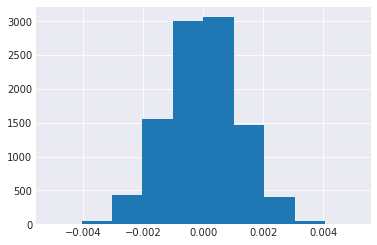

In [34]:
plt.hist(p_diffs);

The histogram is normally distributed. I expected this because with a large enough sample size, the sampling distribution 
of the mean will be normally distributed.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [35]:
obs_diff = converted_treatment - converted_control
obs_diff

-0.0015782389853555567

In [36]:
# compute the p value
pvalue = (p_diffs > obs_diff).mean()
pvalue

0.90559999999999996

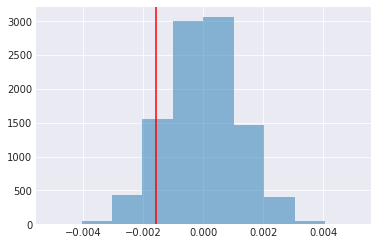

In [37]:
# plotting  line for observed statistic
plt.hist(p_diffs, alpha=.5)
plt.axvline(x=obs_diff, color='red');

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<div class="alert alert-block alert-info">
<b>The following were observed from the results:</b>

1. The value computed in part j is the p value.  P-values are the probability of observing your data or something more extreme in favor of the alternative given the null hypothesis is true.
2. The p-value is 0.9056
3. I also calculated the simulated difference in means which is greater than the observed difference. That is the actual difference from the dataset between the control group conversion rate and the treatment group conversion rate.
4. The p-value which is 0.9056 is greater than the 0.05 type I error threshold. Which means 90.56% of the differences can be attributed to pure chance. The result is not significant. Therefore we fail to reject the null hypothesis.
5. My conclusion will be "the new page has less or equal conversions than the old page".</div>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [38]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


In [39]:
#treatment_df = df2.query('group == "treatment"')


In [40]:
#control_df = df2.query('group == "control"')


In [41]:
# Get the conversions for the groups and count of the groups
old_conversion = df2.query('group == "control" and converted == 1').shape[0]
new_conversion = df2.query('group == "treatment" and converted == 1').shape[0]
n_new
n_old
old_conversion, new_conversion, n_new, n_old

(17489, 17264, 145310, 145274)

In [42]:
#sm.stats.proportion.proportions_ztest
z_score, p_value = sm.stats.proportions_ztest([old_conversion, new_conversion], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<div class="alert alert-block alert-info">
<b>The following were observed from the results:</b>

1. A [z-score](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/) is a numerical measurement used in statistics of a value's relationship to the mean (average) of a group of values(in this case page conversions),  measured in terms of standard deviations from the mean 
2. The z-score here is 1.3109, Therefore the z-score is 1.3109 standard deviations above the mean
3. The z-score confirms the p-value is in the distribution
4. The p- value 0.9051 is greater than 0.05 type 1 error rate. With this we fail to reject the null hypothesis
5. The p_value of the preceeding sample distribution is 0.9056 while the p_value in this section is 0.9051. That is, they are almost the same.  The z-test agrees with the findings in parts j and k.</div>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

LOGISTIC REGRESSION

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [43]:
# Get first few rows of df2
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [44]:
# Create dummy variables for group and landing page
df2[['ab_page', 'ab_page2']] = pd.get_dummies(df2['landing_page'])
df2[['control', 'treatment']] = pd.get_dummies(df2['group'])
df2.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,ab_page,ab_page2,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,0


In [45]:
# Drop columns that wont be used for model 
df3 = df2.drop(['timestamp', 'group', 'landing_page', 'ab_page2', 'treatment', 'control'], axis=1)
df3.head()

,user_id,converted,ab_page
0,851104,0,0
1,804228,0,0
2,661590,0,1
3,853541,0,1
4,864975,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [46]:
# Instantiate regression model, create intercept column and fit to predict conversion
df3['intercept'] = 1
log_mod1 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
results1 = log_mod1.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [47]:
# Get summary of regression model
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:               8.077e-06
Time:                        14:13:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [48]:
# To interprete summary of results, we need to exponentiate
np.exp(-1.9888), np.exp(-0.0150)

(0.13685955841614492, 0.98511193960306265)

In [49]:
# With returned values less than 1, its beneficial to get the reciprocal
1/np.exp(-1.9888), 1/np.exp(-0.0150)

(7.3067603868728614, 1.0151130646157189)

<div class="alert alert-block alert-info">
<b>Interpretation of results:</b>
    For each 1 unit decrease in ab_page, conversion is 1.015 times as likely holding all else constant.</div>

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

<div class="alert alert-block alert-info">
<b></b>
    
1. The p-value associated with ab_page is 0.190
2. The p_values found in Part II are 0.90 and 0.9051.
3. The p-values from part II differ from those in the regression model because in part II we did a one tailed test while in the regression model we used a two tailed approach. [More on the tests here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-the-differences-between-one-tailed-and-two-tailed-tests/) 
4. When using a one-tailed test, you are testing for the possibility of the relationship in one direction and completely disregarding the possibility of a relationship in the other direction. In our hypothesis in Part II, we wanted to prove the alternative hypothesis is true. That is the new page had greater conversions than the old page. 
5. In the regression model, a two-tailed test allots half of your alpha to testing the statistical significance in one direction and half of your alpha to testing statistical significance in the other direction. We are testing for the possibility of the relationship in both directions, i.e both the possibility of the new page having equal or less conversions to the old page and the new page having greater conversions than the old page.</div>


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<div class="alert alert-block alert-info">
<b></b>
The purpose of regression models are: 
    
- planning and control 
- prediction or forecasting. 

The principal adventage of adding other factors to a regression model is that it gives us more of the information available to us to estimate the dependent variable. In reality a variable is usually affected by many other variables. For example it was mentioned earlier that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed. Looking at the time stamps for each visit and when conversion occurs we can look  for possible correlation.
Looking at only a section of the data without considering the other parts can also lead to skewed or unfair conclusions. This is explained by the [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox), which is a phenomenon in probability and statistics, in which a trend appears in several different groups of data but disappears or reverses when these groups are combined . For example: When we are able to study a variety of variables in the data we can uncover the role timing and country play in the conversion of either page. More people might convert at different times of the day for one page over another.
Simpson’s paradox is important for three critical reasons. First, people often expect statistical relationships to be immutable. They often are not. The relationship between two variables might increase, decrease, or even change direction depending on the set of variables being controlled. Second, Simpson’s paradox is not simply an obscure phenomenon of interest only to a small group of statisticians. Simpson’s paradox is actually one of a large class of association paradoxes. Third, Simpson’s paradox reminds researchers that causal inferences, particularly in nonexperimental studies, can be hazardous. Uncontrolled and even unobserved variables that would eliminate or reverse the association observed between two variables might exist (https://www.britannica.com/topic/Simpsons-paradox)

Likely Disadvantages of adding variables:
1. Adding variables might bring up [Multicollinearity](https://statisticalhorizons.com/multicollinearity) which occurs when there are high correlations among predictor variables, leading to unreliable and unstable estimates of regression coefficients.
2. Another likely disadvantage of adding variables is [Covariance](https://medium.com/@thecodingcookie/covariance-correlation-def860c4d4ab). Covariance is a measure of how changes in one variable are associated with changes in a second variable. Specifically, covariance measures the degree to which two variables are linearly associated. Covariance can make interpreting results difficult and even make R values unreliable.</div>




g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [50]:
# Read countries dataframe and view first few rows
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [51]:
# Merge df2 and countries df 
merged_df = df2.merge(countries_df, how='inner')
merged_df.head()

,user_id,timestamp,group,landing_page,converted,ab_page,ab_page2,control,treatment,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,0,US


In [52]:
# Create dummies for country column
merged_df[['CA', 'UK', 'US']] = pd.get_dummies(merged_df['country'])

In [53]:
# View first few rows of merged df
merged_df.head(1)

,user_id,timestamp,group,landing_page,converted,ab_page,ab_page2,control,treatment,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,0,US,0,0,1


In [54]:
# Drop columns that are not useful to the regression model
merged_df = merged_df.drop(['group', 'timestamp', 'landing_page', 'ab_page2', 'treatment', 'control', 'country', 'CA'], axis=1)


In [55]:
# Confirm columns have been dropped
merged_df.head(1)

,user_id,converted,ab_page,UK,US
0,851104,0,0,0,1


In [56]:
# Instantiate regression model, create intercept and fit to predict conversion
merged_df['intercept'] = 1
log_mod2 = sm.Logit(merged_df['converted'], merged_df[['intercept', 'ab_page', 'UK', 'US']])
results2 = log_mod2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [57]:
# Get summary of results
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:               2.323e-05
Time:                        14:13:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [58]:
# To interprete summary of results, we need to exponentiate
np.exp(-0.0149), np.exp(0.0506), np.exp(0.0408)

(0.9852104557227469, 1.0519020483004984, 1.0416437559600236)

In [59]:
# With returned values less than 1, its beneficial to get the reciprocal
1/np.exp(-0.0149)

1.0150115583846535

<div class="alert alert-block alert-info">
<b></b>
The exponentiated values are the multiplicative change in the odds of conversion occurring

1. For each 1 unit decrease in new_page, conversion is 1.015 times as likely holding all else constant
2. If the user lives in the UK, conversion is 1.052 times as likely, holding all else constant.
3. If the user lives in the US, conversion is 1.042 times as likely, holding all else constant. 
4. The p_values for ab_page, UK and US are not significant. They are all greater than 0.05 type I error.
5. Country does not seem to have an impact on conversion.
6. We fail to reject the null hypothesis</div> 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [60]:
merged_df.head()

,user_id,converted,ab_page,UK,US,intercept
0,851104,0,0,0,1,1
1,804228,0,0,0,1,1
2,661590,0,1,0,1,1
3,853541,0,1,0,1,1
4,864975,1,0,0,1,1


In [61]:
# Instantiate regression model, create intercept and fit to predict conversion
merged_df['intercept'] = 1
log_mod3 = sm.Logit(merged_df['converted'], merged_df[['intercept', 'ab_page', 'UK', 'US']])
results3 = log_mod3.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [62]:
# Get results summary
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:               2.323e-05
Time:                        14:13:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [63]:
# Exponentiate in order to interpret them.
np.exp(-0.0149), np.exp(0.0506), np.exp(0.0408)

(0.9852104557227469, 1.0519020483004984, 1.0416437559600236)

In [64]:
# Obtain reciprocal for values less than 1
1/np.exp(-0.0149)

1.0150115583846535

In [65]:
# Explain negative, easier to explain as 1/np.exp()
1/np.exp(-0.0149)

1.0150115583846535

In [66]:
# Combine columns
merged_df['UK_ab_page'] = merged_df['UK'] * merged_df['ab_page']
merged_df['US_ab_page'] = merged_df['US'] * merged_df['ab_page']
merged_df = merged_df.drop('intercept', axis=1)
merged_df.head()

,user_id,converted,ab_page,UK,US,UK_ab_page,US_ab_page
0,851104,0,0,0,1,0,0
1,804228,0,0,0,1,0,0
2,661590,0,1,0,1,0,1
3,853541,0,1,0,1,0,1
4,864975,1,0,0,1,0,0


In [67]:
# Get correlation coeffients using the spearman method
merged_df.corr(method='spearman')

,user_id,converted,ab_page,UK,US,UK_ab_page,US_ab_page
user_id,1.000000,0.001769,-0.001745,-0.002059,0.001187,-0.002814,0.000217
converted,0.001769,1.000000,-0.002432,0.001772,-0.000237,0.001827,-0.002563
ab_page,-0.001745,-0.002432,1.000000,-0.002092,0.001216,0.376626,0.734811
UK,-0.002059,0.001772,-0.002092,1.000000,-0.881979,0.653496,-0.423595
US,0.001187,-0.000237,0.001216,-0.881979,1.000000,-0.576370,0.480278
UK_ab_page,-0.002814,0.001827,0.376626,0.653496,-0.576370,1.000000,-0.276818
US_ab_page,0.000217,-0.002563,0.734811,-0.423595,0.480278,-0.276818,1.000000


<div class="alert alert-block alert-info"><b></b>
    
1. The p-values are not significant as earlier stated.
2. There seems to be a strong correllation(0.73480) between users visiting the new page in the US and conversions. Lets isolate the data for the US below to find if there is a strong reason for users to be shown the new page. **Lets test this below**</div>

In [68]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,ab_page2,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,0


In [69]:
# Create df_usa and drop columns that will not be used
df_usa = df2.merge(countries_df, on='user_id', how='inner')
df_usa = df_usa.query('country == "US"')
df_usa = df_usa.drop(['ab_page', 'ab_page2', 'control', 'treatment'], axis=1)
df_usa.head(2)

,user_id,timestamp,group,landing_page,converted,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,US


In [70]:
# Get count of control group in df_usa
c_count = df_usa.query('group == "control"').count()[0]
c_count

101716

In [71]:
# Get count of converted for control in df_usa
c_usa = df_usa.query('group == "control" and converted == 1').count()[0]
c_usa

12270

In [72]:
# Get count of treatment group in df_usa
t_count = df_usa.query('group == "treatment"').count()[0]
t_count

101903

In [73]:
# Get count of converted or treatment in df_usa
t_usa = df_usa.query('group == "treatment" and converted == 1').count()[0]
t_usa


12072

In [74]:
# Get the z-score and p-value
z_score, p_value = sm.stats.proportions_ztest([c_usa, t_usa], [c_count, t_count], alternative='smaller')
z_score, p_value

(1.5051934564639167, 0.9338628264991603)

<div class="alert alert-block alert-info">
<b></b>

1. The ztest p_value is 0.9339. This is greater than the 0.05 type 1 error level. 
2. Therefore we fail to reject the null hypothesis in USA. People from the USA are no more likely to click on the new_page than Canada or UK and the new_page is  less or equal than the old_page.</div>

**Are Date and Time Correlated With Conversion Rates?**
We will group days into weekdays and weekend to see predict on conversion

In [75]:
# Get the start and end dates 
#df2c = df2.copy()
df2.timestamp.max(), df2.timestamp.min()

('2017-01-24 13:41:54.460509', '2017-01-02 13:42:05.378582')

In [76]:
# Make copy of df2 and drop columns
df_time = df2.copy()
df_time = df_time.drop(['landing_page', 'ab_page2', 'control', 'treatment'], axis=1)
df_time.head(2)

,user_id,timestamp,group,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,0,0
1,804228,2017-01-12 08:01:45.159739,control,0,0


In [77]:
# Extract days from timestamp and create day column
df_time['day'] = pd.DatetimeIndex(df_time['timestamp']).day
df_time.head(2)

,user_id,timestamp,group,converted,ab_page,day
0,851104,2017-01-21 22:11:48.556739,control,0,0,21
1,804228,2017-01-12 08:01:45.159739,control,0,0,12


In [78]:
# group by day and group and get count of converted
day_converted = df_time.groupby(['day', 'group']).count().converted.reset_index()
day_converted.head()

,day,group,converted
0,2,control,2859
1,2,treatment,2853
2,3,control,6590
3,3,treatment,6618
4,4,control,6578


In [79]:
# Get days of the week and add to df_time
df_time['date'] = pd.to_datetime(df_time['timestamp'], format='%Y-%m-%d', errors='ignore')
df_time['day_of_week'] = df_time['date'].dt.strftime('%A')
df_time.head(2)

,user_id,timestamp,group,converted,ab_page,day,date,day_of_week
0,851104,2017-01-21 22:11:48.556739,control,0,0,21,2017-01-21 22:11:48.556739,Saturday
1,804228,2017-01-12 08:01:45.159739,control,0,0,12,2017-01-12 08:01:45.159739,Thursday


In [80]:
# Get weekdays and weekend 
df_time['is_weekday'] = df_time.date.dt.weekday<5
df_time.head()

,user_id,timestamp,group,converted,ab_page,day,date,day_of_week,is_weekday
0,851104,2017-01-21 22:11:48.556739,control,0,0,21,2017-01-21 22:11:48.556739,Saturday,False
1,804228,2017-01-12 08:01:45.159739,control,0,0,12,2017-01-12 08:01:45.159739,Thursday,True
2,661590,2017-01-11 16:55:06.154213,treatment,0,1,11,2017-01-11 16:55:06.154213,Wednesday,True
3,853541,2017-01-08 18:28:03.143765,treatment,0,1,8,2017-01-08 18:28:03.143765,Sunday,False
4,864975,2017-01-21 01:52:26.210827,control,1,0,21,2017-01-21 01:52:26.210827,Saturday,False


In [81]:
# Get dummies for is_weekday and drop columns that are not relevant to model
df_time[['weekend', 'weekday']] = pd.get_dummies(df_time['is_weekday'])
df_time2 = df_time.drop(['timestamp', 'group', 'day', 'date'], axis=1)
df_time2.head()

,user_id,converted,ab_page,day_of_week,is_weekday,weekend,weekday
0,851104,0,0,Saturday,False,1,0
1,804228,0,0,Thursday,True,0,1
2,661590,0,1,Wednesday,True,0,1
3,853541,0,1,Sunday,False,1,0
4,864975,1,0,Saturday,False,1,0


In [82]:
# Create df_time3 column and drop columns not needed for the model
df_time3 = df_time2.drop(['day_of_week', 'is_weekday', 'weekend'], axis=1)
df_time3.head()

,user_id,converted,ab_page,weekday
0,851104,0,0,0
1,804228,0,0,1
2,661590,0,1,1
3,853541,0,1,0
4,864975,1,0,0


In [83]:
# Instantiate regression model, create intercept and fit model
df_time3['intercept'] = 1
log_mod4 = sm.Logit(df_time3['converted'], df_time3[['intercept', 'ab_page', 'weekday']])
results4 = log_mod4.fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:               8.088e-06
Time:                        14:13:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.4230
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9883      0.012   -161.575      0.000      -2.012      -1.964
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
weekday       -0.0006      0.013     -0.049      0.961      -0.026       0.024
==============================================================================
"""

In [84]:
# Exponentiate for  interpretation.
np.exp(-0.0150), np.exp(-0.0006)

(0.98511193960306265, 0.99940017996400543)

In [85]:
# Obtain reciprocal for values less than 1
1/np.exp(-0.0150), 1/np.exp(-0.0006)

(1.0151130646157189, 1.0006001800360054)

<div class="alert alert-block alert-info">
<b></b>

The following were observed from the regression model:
The exponentiated values are the multiplicative change in the odds of conversion occurring.

- For each 1 unit decrease in new_page, conversion is 1.015 times as likely holding all else constant
- For each 1 unit decrease in new_page on weekdays, conversion is 1.0006 times as likely, holding all else constant.
- The p_values for ab_page, and weekday are not significant. They are all greater than 0.05 type I error.
- Weekday does not seem to have an impact on conversion.
- We fail to reject the null hypothesis</div>

Lets looks at conversions during weekends

In [86]:
df_time2.head()

,user_id,converted,ab_page,day_of_week,is_weekday,weekend,weekday
0,851104,0,0,Saturday,False,1,0
1,804228,0,0,Thursday,True,0,1
2,661590,0,1,Wednesday,True,0,1
3,853541,0,1,Sunday,False,1,0
4,864975,1,0,Saturday,False,1,0


In [87]:
# Create df_time4 and drop columns not relevant for model
df_time4 = df_time2.drop(['day_of_week', 'is_weekday', 'weekday'], axis=1)
df_time4.head()

,user_id,converted,ab_page,weekend
0,851104,0,0,1
1,804228,0,0,0
2,661590,0,1,0
3,853541,0,1,1
4,864975,1,0,1


In [88]:
# Instantiate regression model, create intercept and fit to predict conversion
df_time4['intercept'] = 1
log_mod5 = sm.Logit(df_time4['converted'], df_time4[['intercept', 'ab_page', 'weekend']])
results5 = log_mod5.fit()
results5.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:               8.088e-06
Time:                        14:13:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.4230
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9889      0.009   -226.066      0.000      -2.006      -1.972
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
weekend        0.0006      0.013      0.049      0.961      -0.024       0.026
==============================================================================
"""

In [89]:
# Exponentiate for  interpretion.
np.exp(-0.0150), np.exp(0.0006)

(0.98511193960306265, 1.0006001800360054)

In [90]:
# Obtain reciprocal for values less than 1
1/np.exp(-0.0150)

1.0151130646157189

<div class="alert alert-block alert-info">
<b></b>

The following were observed from the regression model:

- For each 1 unit decrease in new_page, conversion is 1.015 times as likely holding all else constant
- During weekends, conversion is 1.0006 as likely, holding all else constant
- The p_values for ab_page and weekend are not significant. They are all greater than 0.05 type I error.
- We fail to reject the null hypothesis</div>

**Lets check for correlation between conversion and days**

In [91]:
# Combine columns
df_time2['weekend_ab_page'] = df_time2['weekend'] * df_time2['ab_page']
df_time2['weekday_ab_page'] = df_time2['weekday'] * df_time2['ab_page']
df_time2 = df_time2.drop('is_weekday', axis=1)
df_time2.head()

,user_id,converted,ab_page,day_of_week,weekend,weekday,weekend_ab_page,weekday_ab_page
0,851104,0,0,Saturday,1,0,0,0
1,804228,0,0,Thursday,0,1,0,0
2,661590,0,1,Wednesday,0,1,0,1
3,853541,0,1,Sunday,1,0,1,0
4,864975,1,0,Saturday,1,0,0,0


In [92]:
# Get correlation
df_time2.corr(method='spearman')

,user_id,converted,ab_page,weekend,weekday,weekend_ab_page,weekday_ab_page
user_id,1.000000,0.001769,-0.001745,0.001194,-0.001194,0.000965,-0.002503
converted,0.001769,1.000000,-0.002432,0.000095,-0.000095,-0.002882,-0.000470
ab_page,-0.001745,-0.002432,1.000000,-0.001712,0.001712,0.397664,0.755594
weekend,0.001194,0.000095,-0.001712,1.000000,-1.000000,0.647587,-0.464103
weekday,-0.001194,-0.000095,0.001712,-1.000000,1.000000,-0.647587,0.464103
weekend_ab_page,0.000965,-0.002882,0.397664,0.647587,-0.647587,1.000000,-0.300547
weekday_ab_page,-0.002503,-0.000470,0.755594,-0.464103,0.464103,-0.300547,1.000000


<div class="alert alert-block alert-info">
<b></b>
Observations:
    
When you look at the ab_page (conversion page), there is a strong correlation between weekday users visiting the new_page and converting (0.755594). It is possible that if you segment this data simply on weekday users you would find that there is strong reason to suggest that weekday users should be shown the new_page. 
Lets do a quick test on this below.</div>

In [93]:
# Users shown old page on weekdays
count_old = df_time.query('group == "control" and weekday == 1').count()[0]
count_old

105376

In [94]:
# Converted users on old page on weekdays
old_convert = df_time.query('group == "control" and weekday == 1 and converted == 1').count()[0]
old_convert

12620

In [95]:
# Users shown new page on weekdays
count_new = df_time.query('group == "treatment" and weekday == 1').count()[0]
count_new

105624

In [96]:
# Converted users on new page on weekdays
new_convert = df_time.query('group == "treatment" and weekday == 1 and converted == 1').count()[0]
new_convert

12611

In [97]:
# Get the z_score and p_value
z_score, p_value = sm.stats.proportions_ztest([old_convert, new_convert], [count_old, count_new ], alternative='smaller')
z_score, p_value

(0.25935687892959919, 0.60232005137881517)

<div class="alert alert-block alert-info">
<b></b>
The ztest gets us a p_value of 0.6023. That is greater than the type I error of 0.05 level of significance.
There for we fail to reject the null hypothesis for weekdays. That is weekday users are no more likely to click on the new_page than on weekend and the new page is less or equal to the old page.</div>

### CONCLUSION

<div class="alert alert-block alert-info">
<b></b>
    
1. Based on my simulatons, logistical regression models and z_tests, there are no significant results. 
2. The p_values in all cases, even on weekdays or weekends are not signficant. 
3. We fail to reject the null hypothesis. The new page is less or equal to the old page.</div>

Some other resources consulted during this project include:
1. http://lindsaymoir.com/wp-content/uploads/2018/05/Analyze_ab_test_results_notebook.html
2. https://stackoverflow.com/questions/58532540/is-it-possible-to-translate-pandas-datetime-to-weekday-weekend-and-season

In [98]:
#from subprocess import call
#call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])